# LLM Agent Experiment

Compare All-LLM agents (DeepSeek-powered) against best and worst performing traditional agents.

**Setup:**
- Non-competitive mode (team player supplier at c=2.0)
- Compare: All-LLM vs Best/Worst of Greedy/UCB/Thompson
- LLM Model: DeepSeek Chat (~$0.04 for full experiment)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import params
import agents
import model
from model import NewsVendorModel

# Set to team player mode
params.SUPPLIER_TEAM_PLAYER = True
params._compute_benchmarks()

print(f"Configuration:")
print(f"  SUPPLIER_TEAM_PLAYER: {params.SUPPLIER_TEAM_PLAYER}")
print(f"  Supplier cost: {params.MANUFACTURING_COST}")
print(f"  Optimal profit: {params.PROFIT_OPTIMA_MAP.get(params.MANUFACTURING_COST, 0):.2f}")
print(f"  Rounds: {params.ROUNDS}")

Computing optimal benchmarks (this may take a moment)...
Retailer optimal at manufacturing cost (c=2.00): price=17.50, quantity=40
Configuration:
  SUPPLIER_TEAM_PLAYER: True
  Supplier cost: 2.0
  Optimal profit: 537.82
  Rounds: 365


## Step 1: Traditional Agents WITHOUT Information Sharing

Test traditional agents with no partner prediction (baseline performance).

In [5]:
# Test traditional agents WITHOUT information sharing
print("\n" + "="*80)
print("PHASE 1: Traditional Agents WITHOUT Information Sharing")
print("="*80)

traditional_configs = [
    (['greedy', 'greedy', 'greedy'], 'All-Greedy'),
    (['ucb', 'ucb', 'ucb'], 'All-UCB'),
    (['thompson', 'thompson', 'thompson'], 'All-Thompson'),
]

traditional_results_no_sharing = []

for agent_types, description in traditional_configs:
    print(f"\nRunning: {description} (no info sharing)")
    
    params.USE_PARTNER_PREDICTION = False
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    final_regret = combined_df['Regret'].cumsum().iloc[-1]
    avg_profit = combined_df['Reward'].mean()
    
    traditional_results_no_sharing.append({
        'Config': f"{description} (No Sharing)",
        'Cumulative_Regret': final_regret,
        'Avg_Profit': avg_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  Cumulative Regret: {final_regret:.2f}")
    print(f"  Average Profit: {avg_profit:.2f}")

# Find best and worst without sharing
best_no_sharing = min(traditional_results_no_sharing, key=lambda x: x['Cumulative_Regret'])
worst_no_sharing = max(traditional_results_no_sharing, key=lambda x: x['Cumulative_Regret'])

print(f"\n" + "-"*80)
print(f"BEST (No Sharing): {best_no_sharing['Config']} - Regret: {best_no_sharing['Cumulative_Regret']:.2f}")
print(f"WORST (No Sharing): {worst_no_sharing['Config']} - Regret: {worst_no_sharing['Cumulative_Regret']:.2f}")
print("-"*80)


PHASE 1: Traditional Agents WITHOUT Information Sharing

Running: All-Greedy (no info sharing)
  Cumulative Regret: 76863.12
  Average Profit: 325.07

Running: All-UCB (no info sharing)
  Cumulative Regret: 34077.10
  Average Profit: 442.93

Running: All-Thompson (no info sharing)
  Cumulative Regret: 37480.86
  Average Profit: 433.23

--------------------------------------------------------------------------------
BEST (No Sharing): All-UCB (No Sharing) - Regret: 34077.10
WORST (No Sharing): All-Greedy (No Sharing) - Regret: 76863.12
--------------------------------------------------------------------------------


## Step 2: Traditional Agents WITH Information Sharing

Test traditional agents with partner prediction enabled (coordinated performance).

In [6]:
# Test traditional agents WITH information sharing
print("\n" + "="*80)
print("PHASE 2: Traditional Agents WITH Information Sharing")
print("="*80)

traditional_results_with_sharing = []

for agent_types, description in traditional_configs:
    print(f"\nRunning: {description} (with info sharing)")
    
    params.USE_PARTNER_PREDICTION = True
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    final_regret = combined_df['Regret'].cumsum().iloc[-1]
    avg_profit = combined_df['Reward'].mean()
    
    traditional_results_with_sharing.append({
        'Config': f"{description} (With Sharing)",
        'Cumulative_Regret': final_regret,
        'Avg_Profit': avg_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  Cumulative Regret: {final_regret:.2f}")
    print(f"  Average Profit: {avg_profit:.2f}")

# Find best and worst with sharing
best_with_sharing = min(traditional_results_with_sharing, key=lambda x: x['Cumulative_Regret'])
worst_with_sharing = max(traditional_results_with_sharing, key=lambda x: x['Cumulative_Regret'])

print(f"\n" + "-"*80)
print(f"BEST (With Sharing): {best_with_sharing['Config']} - Regret: {best_with_sharing['Cumulative_Regret']:.2f}")
print(f"WORST (With Sharing): {worst_with_sharing['Config']} - Regret: {worst_with_sharing['Cumulative_Regret']:.2f}")
print("-"*80)


PHASE 2: Traditional Agents WITH Information Sharing

Running: All-Greedy (with info sharing)
  Cumulative Regret: 68953.72
  Average Profit: 346.98

Running: All-UCB (with info sharing)
  Cumulative Regret: 32635.75
  Average Profit: 446.74

Running: All-Thompson (with info sharing)
  Cumulative Regret: 25016.61
  Average Profit: 467.56

--------------------------------------------------------------------------------
BEST (With Sharing): All-Thompson (With Sharing) - Regret: 25016.61
WORST (With Sharing): All-Greedy (With Sharing) - Regret: 68953.72
--------------------------------------------------------------------------------


## Step 3: LLM Agent WITH Information Sharing

Test All-LLM configuration with partner prediction enabled.

In [7]:
# Test All-LLM configuration WITH information sharing
print(f"\n" + "="*80)
print(f"PHASE 3: All-LLM WITH Information Sharing")
print("="*80)

params.USE_PARTNER_PREDICTION = True
sim_model = NewsVendorModel(agent_type=['llm', 'llm', 'greedy'])

for i in range(params.ROUNDS):
    if (i + 1) % 20 == 0:
        print(f"  Round {i+1}/{params.ROUNDS}")
    sim_model.step()

model_df = sim_model.datacollector.get_model_vars_dataframe()
agent_df = sim_model.datacollector.get_agent_vars_dataframe()

df = agent_df.reset_index()
price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})

combined_df = pd.merge(price_data, qty_data, on="Step")
combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)

final_regret = combined_df['Regret'].cumsum().iloc[-1]
avg_profit = combined_df['Reward'].mean()
final_price = combined_df['Price'].iloc[-100:].mean()
final_quantity = combined_df['Quantity'].iloc[-100:].mean()

llm_result = {
    'Config': 'All-LLM (With Sharing)',
    'Cumulative_Regret': final_regret,
    'Avg_Profit': avg_profit,
    'Final_Price': final_price,
    'Final_Quantity': final_quantity,
    'Combined_DF': combined_df.copy()
}

print(f"\n  ✓ Cumulative Regret: {final_regret:.2f}")
print(f"  ✓ Average Profit: {avg_profit:.2f}")
print(f"  ✓ Final Price: {final_price:.2f}, Quantity: {final_quantity:.1f}")

# Combine all results for comparison
all_results = traditional_results_no_sharing + traditional_results_with_sharing + [llm_result]


PHASE 3: All-LLM WITH Information Sharing
[price] LLM response: 12.5
[price] Suggested: 12.50 → Selected: 12.50
[quantity] LLM response: 20
[quantity] Suggested: 20.00 → Selected: 20.00
[quantity] LLM response: 20.0
[quantity] Suggested: 20.00 → Selected: 20.00
[price] LLM response: 12.5
[price] Suggested: 12.50 → Selected: 12.50
[price] LLM response: 13.0
[price] Suggested: 13.00 → Selected: 13.00
[quantity] LLM response: 20.0
[quantity] Suggested: 20.00 → Selected: 20.00
[quantity] LLM response: To determine the optimal quantity, let's analyze the situation step-by-step:

1. **Price-Demand Relationship**: Higher prices typically lead to lower demand, and vice versa. The predicted price of $12.67 is slightly higher than the previous rounds
[quantity] LLM error: could not convert string to float: "To determine the optimal quantity let's analyze the situation step-by-step:\n\n1. **Price-Demand Relationship**: Higher prices typically lead to lower demand and vice versa. The predicted pr

## Step 4: Visualization - Cumulative Regret

Compare all configurations: Traditional (no sharing), Traditional (with sharing), and LLM (with sharing).

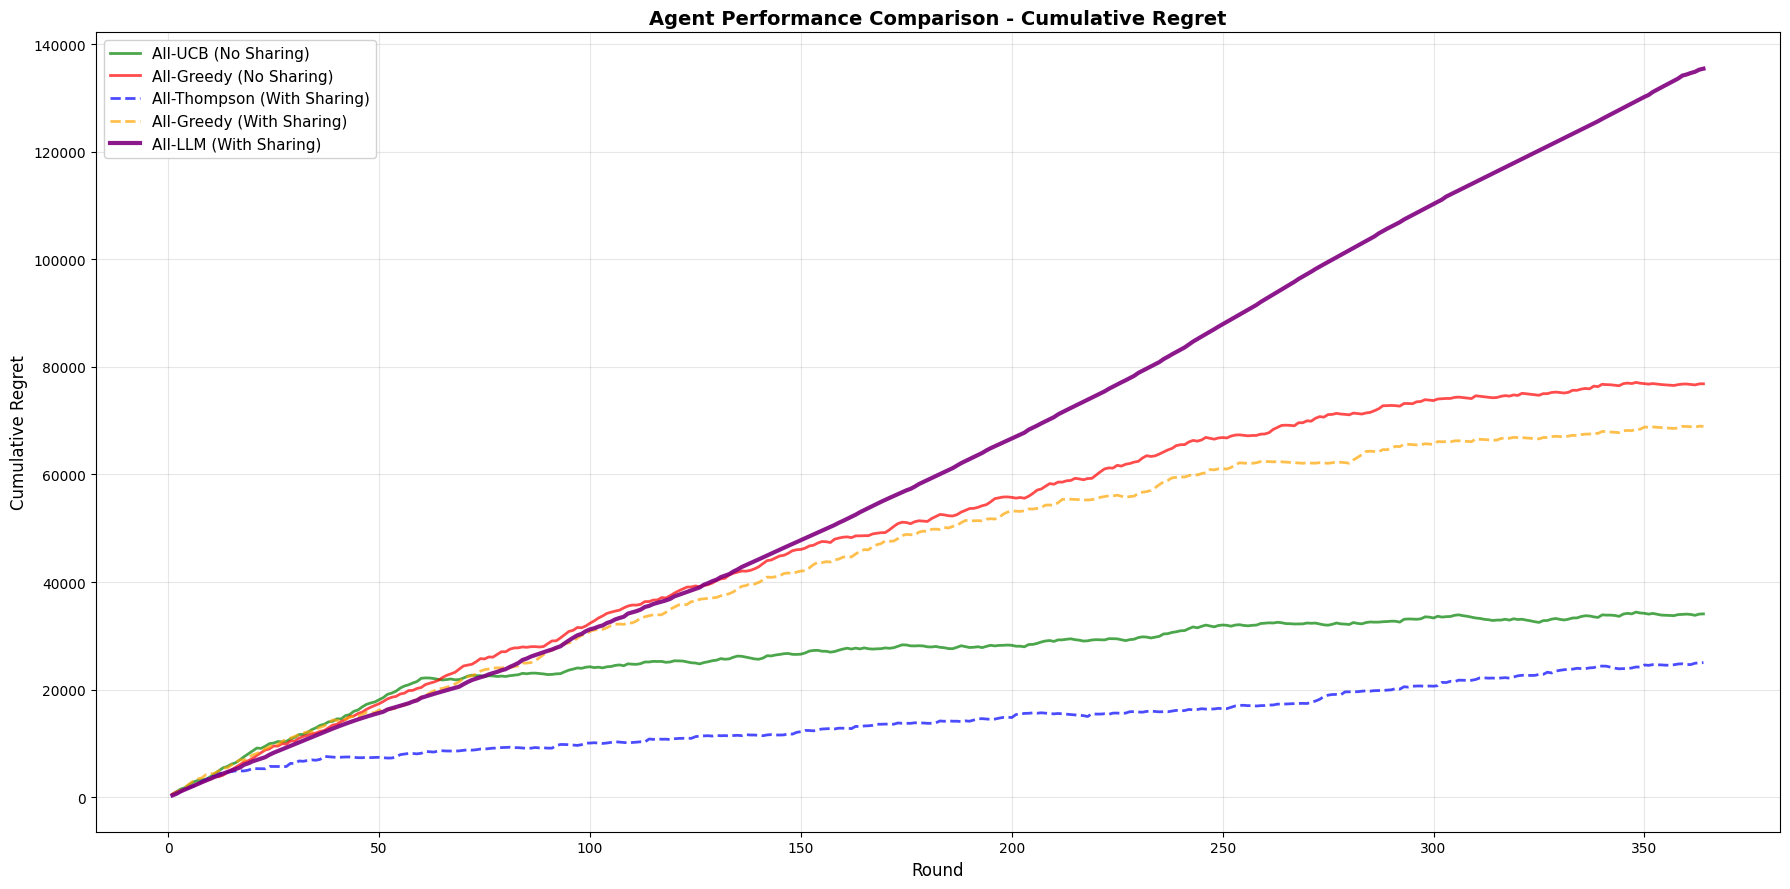

In [21]:
# Plot cumulative regret - comparing key configurations
fig, ax = plt.subplots(figsize=(18, 9))

# Select key results to plot
plot_results = [
    best_no_sharing,
    worst_no_sharing,
    best_with_sharing,
    worst_with_sharing,
    llm_result
]

colors = ['green', 'red', 'blue', 'orange', 'purple']
linestyles = ['-', '-', '--', '--', '-']
linewidths = [2, 2, 2, 2, 3]
alphas = [0.7, 0.7, 0.7, 0.7, 0.9]

for idx, result in enumerate(plot_results):
    df = result['Combined_DF']
    cumulative_regret = df['Regret'].cumsum()
    
    ax.plot(df['Step'], cumulative_regret, 
            label=result['Config'],
            color=colors[idx],
            linestyle=linestyles[idx],
            linewidth=linewidths[idx],
            alpha=alphas[idx])

ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Cumulative Regret', fontsize=12)
ax.set_title('Agent Performance Comparison - Cumulative Regret', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 5: Visualization - Cumulative Profit

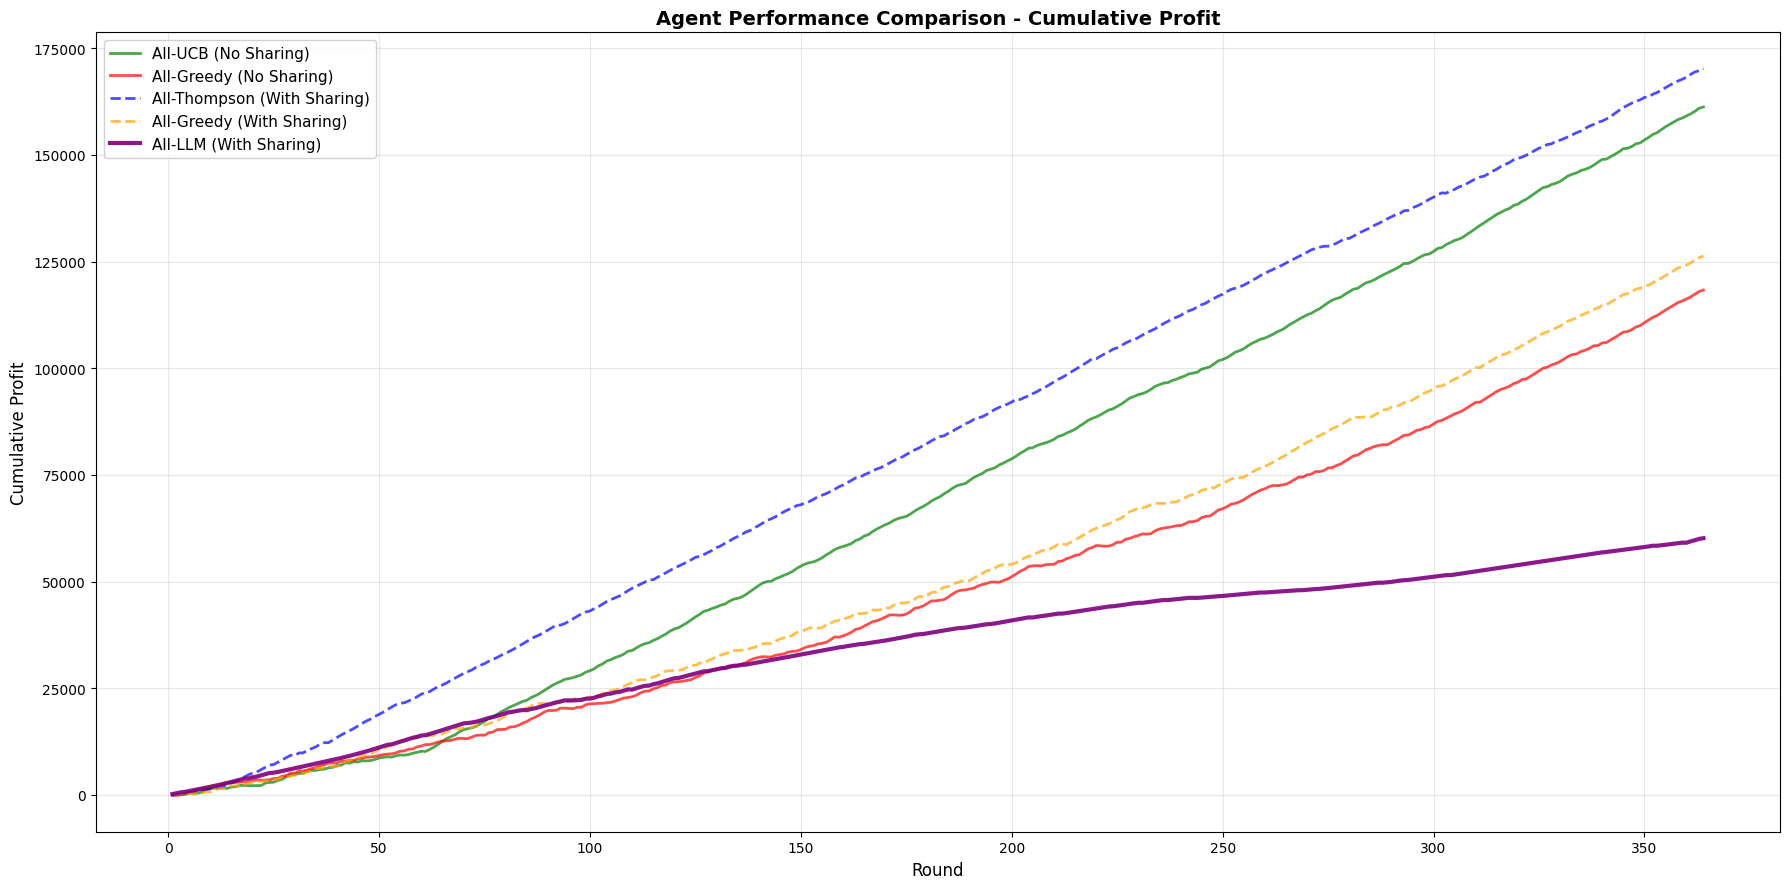

In [22]:
# Plot cumulative profit
fig, ax = plt.subplots(figsize=(18, 9))

# Use same plot_results from regret plot
for idx, result in enumerate(plot_results):
    df = result['Combined_DF']
    cumulative_profit = df['Reward'].cumsum()
    
    ax.plot(df['Step'], cumulative_profit, 
            label=result['Config'],
            color=colors[idx],
            linestyle=linestyles[idx],
            linewidth=linewidths[idx],
            alpha=alphas[idx])

ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Cumulative Profit', fontsize=12)
ax.set_title('Agent Performance Comparison - Cumulative Profit', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 6: Summary Statistics

In [23]:
# Summary table for all results
summary_data = []
for result in all_results:
    summary_data.append({
        'Configuration': result['Config'],
        'Cumulative Regret': f"{result['Cumulative_Regret']:.2f}",
        'Average Profit': f"{result['Avg_Profit']:.2f}",
        'Final Price': f"{result.get('Final_Price', result['Combined_DF']['Price'].iloc[-100:].mean()):.2f}",
        'Final Quantity': f"{result.get('Final_Quantity', result['Combined_DF']['Quantity'].iloc[-100:].mean()):.1f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON SUMMARY")
print("="*80)
display(summary_df)

# Key comparisons
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# 1. Information sharing impact on traditional agents
best_no_regret = best_no_sharing['Cumulative_Regret']
best_with_regret = best_with_sharing['Cumulative_Regret']
sharing_improvement = ((best_no_regret - best_with_regret) / best_no_regret * 100)
print(f"\n1. Information Sharing Impact on Traditional Agents:")
print(f"   Best without sharing: {best_no_regret:.2f}")
print(f"   Best with sharing: {best_with_regret:.2f}")
print(f"   Improvement: {sharing_improvement:.1f}%")

# 2. LLM vs Best Traditional (with sharing)
llm_regret = llm_result['Cumulative_Regret']
llm_vs_best_sharing = ((llm_regret - best_with_regret) / best_with_regret * 100)
status = "✅ Better" if llm_vs_best_sharing < 0 else "❌ Worse"
print(f"\n2. LLM (with sharing) vs Best Traditional (with sharing):")
print(f"   LLM: {llm_regret:.2f}")
print(f"   Best Traditional: {best_with_regret:.2f}")
print(f"   Difference: {llm_vs_best_sharing:+.1f}% {status}")

# 3. LLM vs Best Traditional (without sharing)
llm_vs_best_no_sharing = ((llm_regret - best_no_regret) / best_no_regret * 100)
status2 = "✅ Better" if llm_vs_best_no_sharing < 0 else "❌ Worse"
print(f"\n3. LLM (with sharing) vs Best Traditional (no sharing):")
print(f"   LLM: {llm_regret:.2f}")
print(f"   Best Traditional (no sharing): {best_no_regret:.2f}")
print(f"   Difference: {llm_vs_best_no_sharing:+.1f}% {status2}")

print("\n" + "="*80)


COMPREHENSIVE COMPARISON SUMMARY


,Configuration,Cumulative Regret,Average Profit,Final Price,Final Quantity
0,All-Greedy (No Sharing),76863.12,325.07,18.50,33.5
1,All-UCB (No Sharing),34077.10,442.93,20.00,39.0
2,All-Thompson (No Sharing),37480.86,433.23,19.05,37.0
3,All-Greedy (With Sharing),68953.72,346.98,18.19,33.8
4,All-UCB (With Sharing),32635.75,446.74,18.50,34.0
5,All-Thompson (With Sharing),25016.61,467.56,18.04,35.8
6,All-LLM (With Sharing),135458.60,165.29,20.02,7.2



KEY INSIGHTS

1. Information Sharing Impact on Traditional Agents:
   Best without sharing: 34077.10
   Best with sharing: 25016.61
   Improvement: 26.6%

2. LLM (with sharing) vs Best Traditional (with sharing):
   LLM: 135458.60
   Best Traditional: 25016.61
   Difference: +441.5% ❌ Worse

3. LLM (with sharing) vs Best Traditional (no sharing):
   LLM: 135458.60
   Best Traditional (no sharing): 34077.10
   Difference: +297.5% ❌ Worse



## Step 7: Action Distribution Analysis

## Step 8: LLM Decision History & Convergence Analysis

Deep dive into how LLM agents learn and converge over time.

In [31]:
# 1. Prepare data for detailed analysis
df_llm = llm_result['Combined_DF']
df_best = best_with_sharing['Combined_DF']

# Calculate rolling averages for convergence analysis
window = 20
df_llm['Price_Rolling'] = df_llm['Price'].rolling(window=window, min_periods=1).mean()
df_llm['Quantity_Rolling'] = df_llm['Quantity'].rolling(window=window, min_periods=1).mean()
df_best['Price_Rolling'] = df_best['Price'].rolling(window=window, min_periods=1).mean()
df_best['Quantity_Rolling'] = df_best['Quantity'].rolling(window=window, min_periods=1).mean()

# Define phases for analysis
phases = [
    (0, 100, "Early Phase (1-100)"),
    (100, 200, "Mid Phase (101-200)"),
    (200, 300, "Late Phase (201-300)"),
    (300, 365, "Final Phase (301-365)")
]

print("✓ Data prepared for deep analysis")

✓ Data prepared for deep analysis


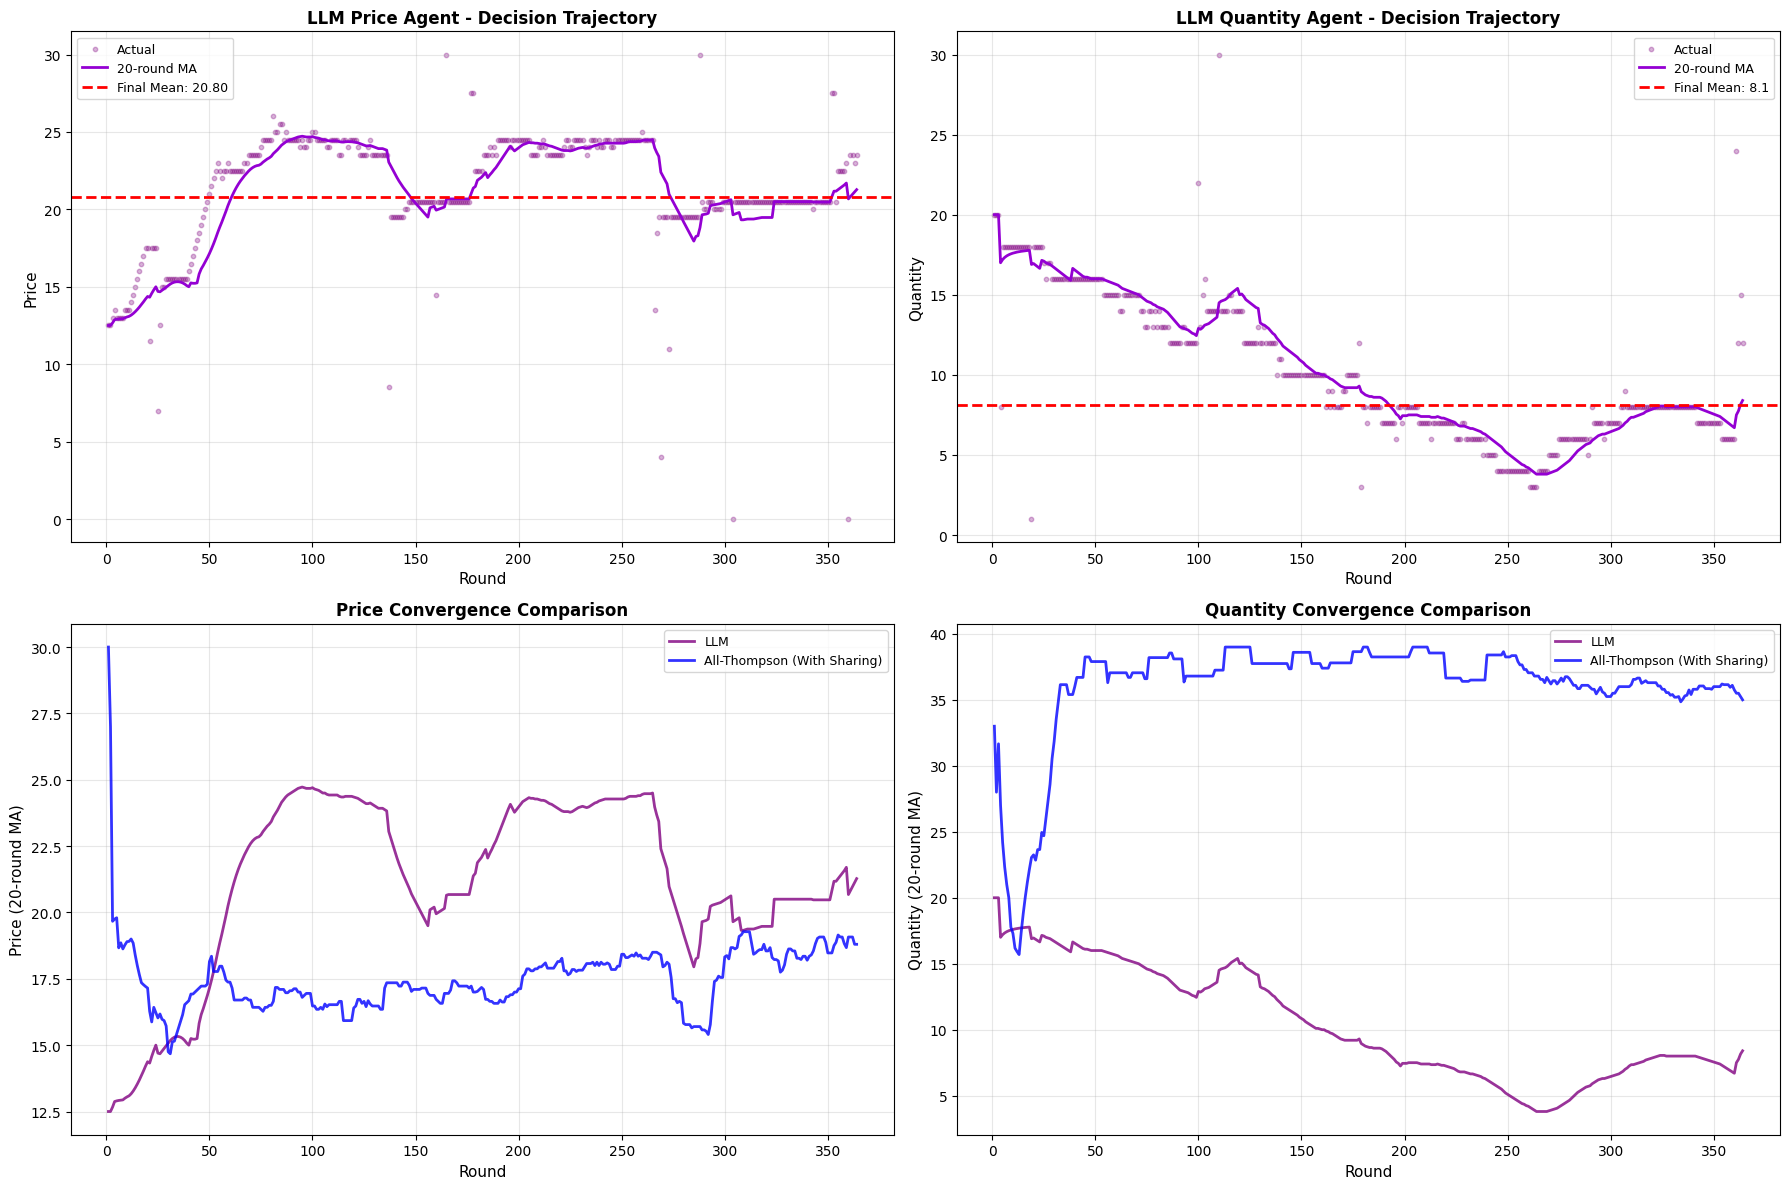

In [32]:
# 2. LLM Decision Trajectory Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top Left: LLM Price Evolution
axes[0, 0].scatter(df_llm['Step'], df_llm['Price'], alpha=0.3, s=10, color='purple', label='Actual')
axes[0, 0].plot(df_llm['Step'], df_llm['Price_Rolling'], color='darkviolet', linewidth=2, label=f'{window}-round MA')
axes[0, 0].axhline(df_llm['Price'].iloc[-50:].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Final Mean: {df_llm["Price"].iloc[-50:].mean():.2f}')
axes[0, 0].set_xlabel('Round', fontsize=11)
axes[0, 0].set_ylabel('Price', fontsize=11)
axes[0, 0].set_title('LLM Price Agent - Decision Trajectory', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Top Right: LLM Quantity Evolution
axes[0, 1].scatter(df_llm['Step'], df_llm['Quantity'], alpha=0.3, s=10, color='purple', label='Actual')
axes[0, 1].plot(df_llm['Step'], df_llm['Quantity_Rolling'], color='darkviolet', linewidth=2, label=f'{window}-round MA')
axes[0, 1].axhline(df_llm['Quantity'].iloc[-50:].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Final Mean: {df_llm["Quantity"].iloc[-50:].mean():.1f}')
axes[0, 1].set_xlabel('Round', fontsize=11)
axes[0, 1].set_ylabel('Quantity', fontsize=11)
axes[0, 1].set_title('LLM Quantity Agent - Decision Trajectory', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Bottom Left: Compare Price Convergence (LLM vs Best Traditional)
axes[1, 0].plot(df_llm['Step'], df_llm['Price_Rolling'], color='purple', linewidth=2, label='LLM', alpha=0.8)
axes[1, 0].plot(df_best['Step'], df_best['Price_Rolling'], color='blue', linewidth=2, label=best_with_sharing['Config'], alpha=0.8)
axes[1, 0].set_xlabel('Round', fontsize=11)
axes[1, 0].set_ylabel('Price (20-round MA)', fontsize=11)
axes[1, 0].set_title('Price Convergence Comparison', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# Bottom Right: Compare Quantity Convergence
axes[1, 1].plot(df_llm['Step'], df_llm['Quantity_Rolling'], color='purple', linewidth=2, label='LLM', alpha=0.8)
axes[1, 1].plot(df_best['Step'], df_best['Quantity_Rolling'], color='blue', linewidth=2, label=best_with_sharing['Config'], alpha=0.8)
axes[1, 1].set_xlabel('Round', fontsize=11)
axes[1, 1].set_ylabel('Quantity (20-round MA)', fontsize=11)
axes[1, 1].set_title('Quantity Convergence Comparison', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# 3. Convergence Statistics
print("=" * 80)
print("CONVERGENCE ANALYSIS")
print("=" * 80)

# Calculate variance in late phase for both agents
for agent_name, df in [("LLM", df_llm), ("Best Traditional", df_best)]:
    late_price = df[df['Step'] >= 300]['Price']
    late_quantity = df[df['Step'] >= 300]['Quantity']
    
    print(f"\n{agent_name} Agent:")
    print(f"  Late-phase Price: μ={late_price.mean():.2f}, σ={late_price.std():.2f}, CV={late_price.std()/late_price.mean():.3f}")
    print(f"  Late-phase Quantity: μ={late_quantity.mean():.1f}, σ={late_quantity.std():.1f}, CV={late_quantity.std()/late_quantity.mean():.3f}")

# Convergence threshold: Mean absolute deviation from final 20-round average
converged_price_llm = df_llm['Price'].iloc[-20:].mean()
converged_qty_llm = df_llm['Quantity'].iloc[-20:].mean()
converged_price_best = df_best['Price'].iloc[-20:].mean()
converged_qty_best = df_best['Quantity'].iloc[-20:].mean()

print(f"\n{'-'*80}")
print("Final Converged Values (Last 20 rounds):")
print(f"  LLM: Price={converged_price_llm:.2f}, Quantity={converged_qty_llm:.1f}")
print(f"  Best Traditional: Price={converged_price_best:.2f}, Quantity={converged_qty_best:.1f}")
print(f"{'-'*80}")

CONVERGENCE ANALYSIS

LLM Agent:
  Late-phase Price: μ=20.42, σ=3.94, CV=0.193
  Late-phase Quantity: μ=8.0, σ=2.4, CV=0.305

Best Traditional Agent:
  Late-phase Price: μ=18.64, σ=2.78, CV=0.149
  Late-phase Quantity: μ=35.8, σ=2.7, CV=0.075

--------------------------------------------------------------------------------
Final Converged Values (Last 20 rounds):
  LLM: Price=21.27, Quantity=8.4
  Best Traditional: Price=18.80, Quantity=35.0
--------------------------------------------------------------------------------


In [34]:
# 4. Learning Efficiency by Phase
print("\n" + "=" * 80)
print("LEARNING EFFICIENCY BY PHASE")
print("=" * 80)

for phase_start, phase_end, phase_name in phases:
    llm_phase = df_llm[(df_llm['Step'] >= phase_start) & (df_llm['Step'] < phase_end)]
    best_phase = df_best[(df_best['Step'] >= phase_start) & (df_best['Step'] < phase_end)]
    
    print(f"\n{phase_name}:")
    print(f"  LLM Profit/Round: {llm_phase['Reward'].mean():.2f} (σ={llm_phase['Reward'].std():.2f})")
    print(f"  Best Traditional Profit/Round: {best_phase['Reward'].mean():.2f} (σ={best_phase['Reward'].std():.2f})")
    
    # Calculate improvement rate (slope of profit over phase)
    llm_trend = np.polyfit(llm_phase['Step'], llm_phase['Reward'], 1)[0]
    best_trend = np.polyfit(best_phase['Step'], best_phase['Reward'], 1)[0]
    print(f"  Profit Trend ($/round): LLM={llm_trend:.4f}, Best Traditional={best_trend:.4f}")


LEARNING EFFICIENCY BY PHASE

Early Phase (1-100):
  LLM Profit/Round: 227.84 (σ=79.56)
  Best Traditional Profit/Round: 433.16 (σ=179.77)
  Profit Trend ($/round): LLM=-0.0044, Best Traditional=2.8784

Mid Phase (101-200):
  LLM Profit/Round: 181.57 (σ=73.18)
  Best Traditional Profit/Round: 487.13 (σ=122.90)
  Profit Trend ($/round): LLM=-0.8958, Best Traditional=-0.0855

Late Phase (201-300):
  LLM Profit/Round: 102.84 (σ=47.51)
  Best Traditional Profit/Round: 480.02 (σ=145.11)
  Profit Trend ($/round): LLM=-0.5550, Best Traditional=-0.7759

Final Phase (301-365):
  LLM Profit/Round: 141.04 (σ=50.44)
  Best Traditional Profit/Round: 470.67 (σ=147.25)
  Profit Trend ($/round): LLM=0.2501, Best Traditional=1.1602


In [35]:
# 5. Exploration Patterns
print("\n" + "=" * 80)
print("EXPLORATION PATTERNS")
print("=" * 80)

for agent_name, df in [("LLM", df_llm), ("Best Traditional", df_best)]:
    # Count unique actions in each phase
    print(f"\n{agent_name} Agent Exploration:")
    for phase_start, phase_end, phase_name in phases:
        phase_data = df[(df['Step'] >= phase_start) & (df['Step'] < phase_end)]
        unique_prices = phase_data['Price'].nunique()
        unique_qtys = phase_data['Quantity'].nunique()
        total_decisions = len(phase_data)
        
        print(f"  {phase_name}: {unique_prices} unique prices, {unique_qtys} unique quantities (out of {total_decisions} decisions)")
        
    # Calculate action space coverage
    price_range = df['Price'].max() - df['Price'].min()
    qty_range = df['Quantity'].max() - df['Quantity'].min()
    print(f"  Total Range Explored: Price [{df['Price'].min():.2f}, {df['Price'].max():.2f}] (Δ={price_range:.2f}), "
          f"Quantity [{df['Quantity'].min():.0f}, {df['Quantity'].max():.0f}] (Δ={qty_range:.0f})")


EXPLORATION PATTERNS

LLM Agent Exploration:
  Early Phase (1-100): 30 unique prices, 10 unique quantities (out of 99 decisions)
  Mid Phase (101-200): 12 unique prices, 14 unique quantities (out of 100 decisions)
  Late Phase (201-300): 12 unique prices, 6 unique quantities (out of 100 decisions)
  Final Phase (301-365): 7 unique prices, 7 unique quantities (out of 65 decisions)
  Total Range Explored: Price [0.00, 30.00] (Δ=30.00), Quantity [1, 30] (Δ=29)

Best Traditional Agent Exploration:
  Early Phase (1-100): 16 unique prices, 14 unique quantities (out of 99 decisions)
  Mid Phase (101-200): 11 unique prices, 5 unique quantities (out of 100 decisions)
  Late Phase (201-300): 13 unique prices, 6 unique quantities (out of 100 decisions)
  Final Phase (301-365): 11 unique prices, 5 unique quantities (out of 65 decisions)
  Total Range Explored: Price [0.50, 30.00] (Δ=29.50), Quantity [0, 39] (Δ=39)


In [37]:
# 6. Final Summary: LLM vs Traditional Agents
print("\n\n" + "=" * 80)
print("FINAL VERDICT: LLM vs TRADITIONAL AGENTS WITH INFORMATION SHARING")
print("=" * 80)

# Compare final performance (calculate total cumulative profit)
llm_final_profit = llm_result['Combined_DF']['Reward'].sum()
best_final_profit = best_with_sharing['Combined_DF']['Reward'].sum()
profit_diff = llm_final_profit - best_final_profit
profit_pct = (profit_diff / best_final_profit) * 100

print(f"\n1. CUMULATIVE PERFORMANCE:")
print(f"   LLM Total Profit: ${llm_final_profit:,.2f}")
print(f"   Best Traditional: ${best_final_profit:,.2f} ({best_with_sharing['Config']})")
print(f"   Difference: ${profit_diff:,.2f} ({profit_pct:+.2f}%)")

# Compare convergence quality
llm_late_std_price = df_llm[df_llm['Step'] >= 300]['Price'].std()
best_late_std_price = df_best[df_best['Step'] >= 300]['Price'].std()

print(f"\n2. CONVERGENCE QUALITY:")
print(f"   LLM Price Stability (σ): {llm_late_std_price:.2f}")
print(f"   Best Traditional Price Stability (σ): {best_late_std_price:.2f}")
print(f"   Winner: {'LLM' if llm_late_std_price < best_late_std_price else 'Traditional'} (lower is better)")

# Compare decision diversity
llm_unique = df_llm['Price'].nunique() + df_llm['Quantity'].nunique()
best_unique = df_best['Price'].nunique() + df_best['Quantity'].nunique()

print(f"\n3. DECISION DIVERSITY:")
print(f"   LLM Unique Actions: {llm_unique}")
print(f"   Best Traditional Unique Actions: {best_unique}")
print(f"   Winner: {'LLM' if llm_unique > best_unique else 'Traditional'} (higher suggests better exploration)")

# Automated verdict
print(f"\n" + "-" * 80)
if profit_diff > 0 and llm_late_std_price < best_late_std_price:
    verdict = "✅ CLEAR WIN for LLM (Higher profit + Better stability)"
elif profit_diff > 0:
    verdict = "✅ LLM WINS on profit (but check stability tradeoff)"
elif llm_late_std_price < best_late_std_price:
    verdict = "⚖️  MIXED: LLM has better stability but lower profit"
else:
    verdict = "❌ Traditional agents outperform LLM"

print(f"VERDICT: {verdict}")
print("-" * 80)



FINAL VERDICT: LLM vs TRADITIONAL AGENTS WITH INFORMATION SHARING

1. CUMULATIVE PERFORMANCE:
   LLM Total Profit: $60,165.90
   Best Traditional: $170,190.72 (All-Thompson (With Sharing))
   Difference: $-110,024.81 (-64.65%)

2. CONVERGENCE QUALITY:
   LLM Price Stability (σ): 3.94
   Best Traditional Price Stability (σ): 2.78
   Winner: Traditional (lower is better)

3. DECISION DIVERSITY:
   LLM Unique Actions: 57
   Best Traditional Unique Actions: 50
   Winner: LLM (higher suggests better exploration)

--------------------------------------------------------------------------------
VERDICT: ❌ Traditional agents outperform LLM
--------------------------------------------------------------------------------
